In [1]:
import numpy as np
import os

# hack to import camvid_data_manager and the rest of the files like segnet_model, etc.
import sys
sys.path.append('../')

import camvid_data_manager as cdm
import segnet_model
import kaggle_data_generator as kdg
import utils
from keras.callbacks import TensorBoard
from utils import init_logging, log_debug, log_info, log_warning, log_critical, log_exception

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

## 1 Load segnet carvana model. (Model loaded with trained weights from the carvana image masking)
##   data.
%matplotlib inline

init_logging("../image_segmentation.ini")
log_info("Current working directory is %s" %os.getcwd())

## 1. Load the model. If that fails due to lack of model information or weights, bail.


segnet_instance = segnet_model.SegnetModel("../image_segmentation.ini", "Camvid")
model = segnet_instance.load_model("optimizers.Adam(lr=0.0001)", loss_type = segnet_model.LossType.CROSS_ENTROPY_LOSS, num_classes=12)
if (model == None):
    log_warning("Failed to load model. Please train the model first before continuing further tests.")

log_info("Loaded model successfully")


Using TensorFlow backend.
INFO:root:Current working directory is /home/ubuntu/illinois/deeplearning/deep_learning_project/src/tests
INFO:root:Total number of gpus 0
INFO:root:Use MaxPoolingIndices 1
INFO:root:
Opened model file /home/ubuntu/illinois/deeplearning/deep_learning_project/src/camvid/camvid_image_segmentation_nn_pool.json


Logging level is  20
Logging level is  20
2 No such file or directory


INFO:root:In EncoderMaxPool2D._pooling_function()
INFO:root:In UpsampleUsingMaxPoolingIndices.call()
INFO:root:
Loading weights from file /home/ubuntu/illinois/deeplearning/deep_learning_project/src/camvid/camvid_image_segmentation_nn_pool.h5
INFO:root:Using sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully


In [2]:
import cv2
from scipy import misc
import utils
import matplotlib.pyplot as plt
import shutil, random, os

%matplotlib inline

# https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/Segnet-Evaluation-Visualization.ipynb
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

# https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/Segnet-Evaluation-Visualization.ipynb
def convert_mask_to_rgb(mask):
    r = mask.copy()
    g = mask.copy()
    b = mask.copy()
    
    for l in range(0,11):
        r[mask==l]=label_colours[l,0]
        g[mask==l]=label_colours[l,1]
        b[mask==l]=label_colours[l,2]

    rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    return rgb

# Returns a random collection of image and mask paths of size |count|
def generate_image_and_mask_paths(folder, count):
    data_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "dataPath")
    seed = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    image_file_names = random.sample(os.listdir(data_path + "/" + folder), count)

    image_paths = []
    mask_paths = []
    for image_file_name in image_file_names:
        image_paths.append(data_path + "/" + folder + "/" + image_file_name)
        mask_paths.append(data_path + "/" + folder + "annot/" + image_file_name)
    
    return image_paths, mask_paths

# Helper function to test #count images in the |folder|. The function loads the images and
# calls the predict() function on the model loaded above. The returned mask from predict is plotted
# along with the image, actual mask and the predicted mask.
def test_images(folder, count):
    data_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "dataPath")
    image_width = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageWidth"))
    image_height = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageHeight"))
    seed = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    log_info("Image width %d, Image height %d" %(image_width, image_height))
    log_info("datapath %s" %(data_path))

    image_paths, mask_paths = generate_image_and_mask_paths(folder, count)
    
    for i in range(0, len(image_paths)):
        image_path = image_paths[i]
        log_info("Image path is %s" %image_path)
        image = misc.imread(image_path)
        image = cv2.resize(image, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255

        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        mask = np.argmax(predicted, axis = -1)
        mask = np.asarray(convert_mask_to_rgb(np.squeeze(mask)))
        
        original_mask = misc.imread(mask_paths[i])
        original_mask = cv2.resize(original_mask, (image_width, image_height))
        original_mask = np.asarray(convert_mask_to_rgb(np.squeeze(original_mask)))

        images = []
        cmaps = []

        images.append(image)
        images.append(original_mask)
        images.append(mask)
        
        cmaps.append(None)
        cmaps.append(None)
        cmaps.append(None)        

        utils.plot_images(images, cmaps)    


INFO:root:Testing images from the Camvid train folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_07170.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0006R0_f00930.png
INFO:root:In plot_images. Total images 3


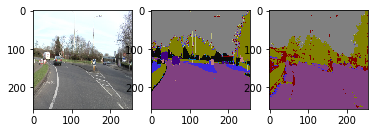

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0001TP_006930.png
INFO:root:In plot_images. Total images 3


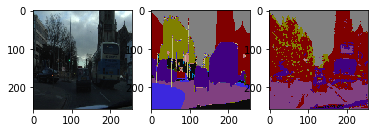

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_08280.png
INFO:root:In plot_images. Total images 3


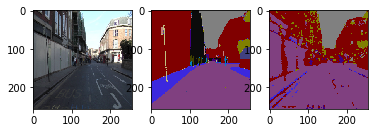

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0006R0_f01170.png
INFO:root:In plot_images. Total images 3


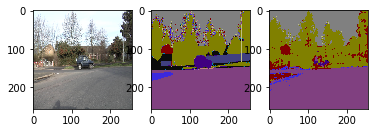

INFO:root:Done with train image tests


In [3]:
## 2. Testing training images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline


log_info("Testing images from the Camvid train folder")

test_images("train", 5)
    
log_info("Done with train image tests")


INFO:root:Testing images from the Camvid validation folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08117.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


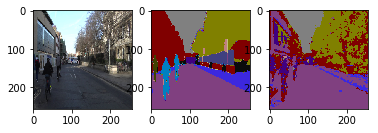

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08073.png
INFO:root:In plot_images. Total images 3


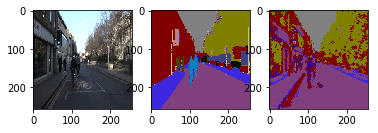

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08081.png
INFO:root:In plot_images. Total images 3


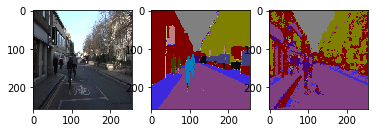

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_07993.png
INFO:root:In plot_images. Total images 3


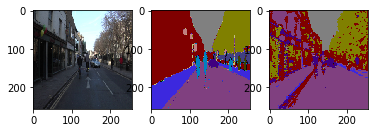

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08085.png
INFO:root:In plot_images. Total images 3


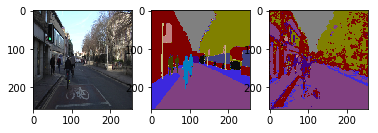

INFO:root:Done with tests


In [4]:
## 3. Testing validation images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline
log_info("Testing images from the Camvid validation folder")

test_images("val", 5)
    
log_info("Done with tests")

INFO:root:Testing images from the Camvid test folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f03960.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


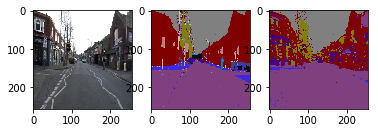

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f03720.png
INFO:root:In plot_images. Total images 3


INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f03600.png
INFO:root:In plot_images. Total images 3


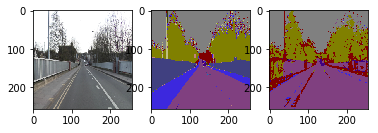

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f03750.png
INFO:root:In plot_images. Total images 3


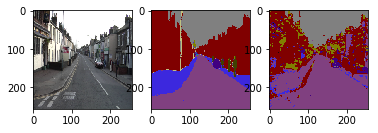

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f00390.png
INFO:root:In plot_images. Total images 3


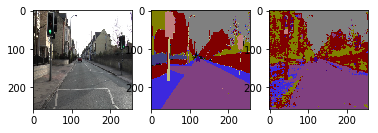

INFO:root:Done with tests


In [5]:
## 4. Testing test images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline
log_info("Testing images from the Camvid test folder")

test_images("test", 5)
    
log_info("Done with tests")

In [6]:
## 5. Testing one of the videos in the Camvid data set with hyperparameters of Adam with 
##    learning rate of 0.0001, image size of  256 x 256 x 3 and batch size of 4. 
##    Validation accuracy of 0.8336%

# The video 0005VD.mxf was downloaded from here ftp://svr-ftp.eng.cam.ac.uk/pub/eccv/
# and converted to AVI format.

import cv2
import matplotlib.pyplot as plt
from IPython import display
import utils
import numpy as np

utils.init_logging("../image_segmentation.ini")

data_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "dataPath")
image_width = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageWidth"))
image_height = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageHeight"))

utils.log_info("Image width %d, Image height %d" %(image_width, image_height))

vid = cv2.VideoCapture(data_path + "/videos/" + '0006R0.avi')
# Check if camera opened successfully
if (vid.isOpened()== False): 
  print("Error opening video stream or file")

frame_count = 0

try:
    while (True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            print("Released video resource")
            break

        image = cv2.resize(frame, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255
        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        mask = np.argmax(predicted, axis = -1)

        images = []
        cmaps = []
        
        mask = np.asarray(convert_mask_to_rgb(np.squeeze(mask)))
        
        images.append(image)
        images.append(mask)
        cmaps.append(None)
        cmaps.append(None)
        
        #utils.plot_images(images, cmaps, False)
        
        plot = plt.figure()
        for i in range(len(images)):
           plot.add_subplot(1, 2, i + 1)
           image = np.squeeze(images[i])
           if (cmaps[i] == 'gray'):
               image = image.astype(np.uint8)
           plt.imshow(image, cmap = cmaps[i])
        
        display.display(plt.gcf())
        display.clear_output(wait = True)
        plt.close()
        frame_count = frame_count + 1
        if (frame_count == 100):
            print("Read 100 frames. Exiting")
            vid.release()
            break
        
except KeyboardInterrupt:
    vid.release()
    print("Released video resource")


Read 100 frames. Exiting


In [ ]:
import cv2
from scipy import misc
%matplotlib inline


def populate_original_and_predicted_masks(folder):
    data_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "dataPath")
    image_width = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageWidth"))
    image_height = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageHeight"))
    seed = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    log_info("Image width %d, Image height %d" %(image_width, image_height))
    log_info("datapath %s" %(data_path))
    
    original_mask = []
    predicted_masks = []
    for image_path in os.listdir(data_path + "/" + folder):
        
        image = misc.imread(data_path + "/" + folder + "/" + image_path)
        image = cv2.resize(image, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255
        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        predicted_mask = np.argmax(predicted, axis = -1)
        predicted_masks.append(predicted_mask)
        
        original_mask_folder = folder + "annot"
        image_original_mask = misc.imread(data_path + "/" + original_mask_folder + "/" + image_path)
        image_original_mask = cv2.resize(image_original_mask, (image_width, image_height))
        
        original_mask.append(image_original_mask)


    return  original_mask, predicted_masks

original_mask,  predicted_masks = populate_original_and_predicted_masks("test")

In [ ]:
from sklearn.metrics import classification_report
predicted = []
actual = []
for i in range(len(predicted_masks)):
    p = np.array(predicted_masks[i])
    a = np.array(original_mask[i]) 
    predicted.extend( np.reshape(p, (np.product(p.shape),)))
    actual.extend( np.reshape(a, (np.product(a.shape),)))
target_names = ["Sky", "Building", "Pole", "Road", "Pavement", "Tree", "SignSymbol", "Fence", "Car", "Pedestrian", "Bicyclist", "Unlabelled"]
log_info(classification_report(actual,predicted, target_names=target_names))